### Project Report
# Predicting Usage of a Video Game Research Server

By Victoria Zhou

## Introduction

Video games are a major part of modern entertainment and social interaction. As games grow more complex, understanding player behaviour helps improve design and infrastructure. Using data collected from the UBC Computer Science research group, I analyzed whether certain player traits can predict newsletter subscription.

My guiding question is: Can age and played hours predict whether a player subscribes to the game-related newsletter?

I analyzed the following dataset with **individual player information.**

### Players Dataset Summary

| Variable Name | Variable Type | Description |
| --- | ----------- | -----------|
| experience | factor | Level of gameplay experience (Beginner, Amateur, Regular, Pro, Veteran).|
| subscribe | logical | Whether the player subscribed to the newsletter (TRUE or FALSE).|
| hashedEmail | character | Hashed email identifier (used to anonymize individual players).|
| played_hours | numeric | Total number of hours the player has spent on the server.|
| name | character | Player’s in-game display name (not used in analysis).|
| gender | factor | Player’s self-reported gender (Male, Female, Non-binary, Two-Spirited, Agender, Prefer not to say, Other).|
| Age | integer | Player’s age in years.|

**Summary Statistics & Key Insights**
- Number of observations: 196 players
- Number of variables: 7
- Source: Minecraft research server
- Collection Method: Player info collected at account registration, and gameplay time was recorded during server use.
- Subscription: 144 players subscribed (73%)
- Age: Mean = 20.5, Median = 19, Range = 8–50 
- Playtime: Mean = 5.85 hours

**Observations & Issues**
- Missing values: Only in Age (2 cases)
- Limited behaviour tracking: No session or in-game activity metrics
- Sampling bias: Likely overrepresents younger users (median age = 19)

## Methods & Results

### Preliminary Exploratory Data Analysis

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### 1. Read and Tidy Data
For this project, I decided to use the variables age, played hours, and subscribe from the Minecraft player dataset.

To tidy and modify our data, I used the mutate and `as_factor` functions to convert the experience variable from logical type to factor type so that I could treat it as a categorical variable in the analysis. Then, I used the select function to create a data frame with only the columns I wanted to analyze.

In [2]:
#players <- read_csv("players.csv")
# to demonstrate that the dataset is readable from local into R
# I first downloaded the Minecraft player dataset provided by the UBC research group
# Then, I saved the file in my local directory for easy access
# Finally, I used read_csv to import the raw data into R for analysis
players <- read_csv("players.csv")
head(players)


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [3]:
players<-players|>
mutate(subscribe=as_factor(subscribe))|>
select(subscribe, played_hours,Age)
players

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
⋮,⋮,⋮
FALSE,0.0,17
FALSE,2.3,17
TRUE,0.2,NA


### 2. Summarize Data
First, the `set.seed` function is used to ensure that results are reproducible.

Then, the data is split into 75% for training and 25% for testing using the initial_split function.

To summarize the training data, I counted the percentage of player who subscribed to the game-related newsletter using the `group_by` and `summarize` functions.

In [4]:
set.seed(123) # ensures replicability
players_split <- initial_split(players, prop = 0.75, strata = subscribe) 
players_training <- training(players_split)
players_testing <- testing(players_split)

In [5]:
glimpse(players_training)
glimpse(players_testing)

Rows: 147
Columns: 3
$ subscribe    <fct> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, F…
$ played_hours <dbl> 0.0, 0.1, 0.0, 0.0, 1.4, 0.0, 0.0, 0.9, 0.0, 0.1, 0.2, 0.…
$ Age          <dbl> 22, 17, 23, 33, 25, 24, 23, 18, 42, 22, 37, 28, 23, 17, 1…
Rows: 49
Columns: 3
$ subscribe    <fct> TRUE, FALSE, TRUE, FALSE, TRUE, TRUE, TRUE, FALSE, TRUE, …
$ played_hours <dbl> 3.8, 0.0, 0.7, 0.0, 0.0, 48.4, 0.3, 0.1, 0.6, 0.4, 5.6, 2…
$ Age          <dbl> 17, 17, 21, 21, 17, 17, 8, 18, 26, 20, 17, 11, 17, 15, 22…


In [6]:
cat("Table 1: Number and Percentage of Players that Subscribe to the Newsletter\n")
players_proportions <- players_training |>
                          group_by(subscribe) |>
                          summarize(count = n()) |>
                          mutate(percent = 100*count/nrow(players_training))
players_proportions

Table 1: Number and Percentage of Players that Subscribe to the Newsletter


subscribe,count,percent
<fct>,<int>,<dbl>
FALSE,39,26.53061
TRUE,108,73.46939


In [7]:
cat("Table 2: Average Predictor Values for Subscribers and Non-subscribers")
comparison <- players_training |>
                group_by(subscribe) |>
                summarize(avg_age = mean(Age, na.rm=TRUE),
                          avg_played_hours = mean(played_hours, na.rm=TRUE))
comparison

Table 2: Average Predictor Values for Subscribers and Non-subscribers

subscribe,avg_age,avg_played_hours
<fct>,<dbl>,<dbl>
FALSE,23.87179,0.4641026
TRUE,19.93396,9.7250000


### 3. Exploratory Data Visualization
I created a scatterplot to visualize relationship between age and played_hours variables. I selected my own colorblind-friendly colors—"darkorange" for orange and "steelblue" for blue—and passed them as the values argument to the scale_color_manual function.

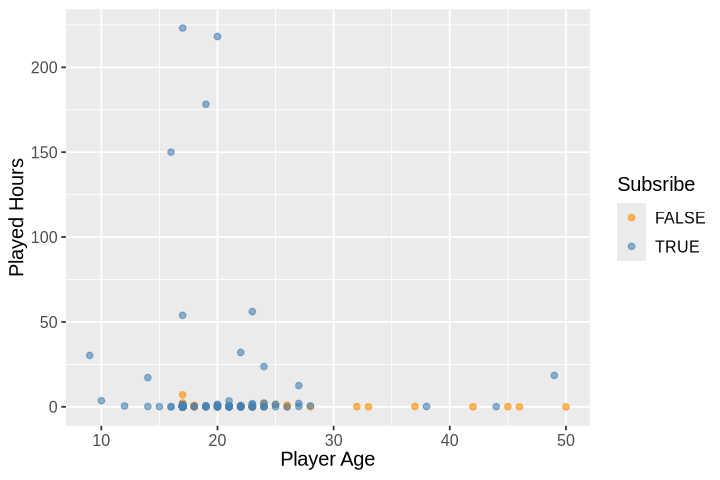

In [20]:
options(repr.plot.width = 6, repr.plot.height = 4)
exploratory_plot<-ggplot(players_training, aes(x = Age, y = played_hours,color=subscribe)) +
  geom_point(alpha = 0.6) +
  labs(x = "Player Age",
       y = "Played Hours",
       color = "Subsribe") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))

exploratory_plot

The scatterplot illustrates the relationship between player age and played hours, with points colored by subscription status. Most players, regardless of whether they subscribed to the newsletter, have relatively low total playtime, with a noticeable cluster below 50 hours. Subscribed players appear more frequently among younger individuals—particularly those under the age of 20—and tend to have slightly higher played hours. In contrast, non-subscribed players are more evenly distributed across different age groups, though they also generally exhibit low playtime. While there is no clear linear relationship between age and hours played, the plot suggests that younger, more active players may be more likely to subscribe. These patterns support the idea that age and engagement could be meaningful predictors in a model aiming to classify subscription behaviour.

## KNN Classification Algorithm

To predict whether a player subscribes to the game-related newsletter, I used a k-nearest neighbours (KNN) classification model. KNN classification is appropriate for this task because the response variable (subscribe) is binary.

**Why this method is appropriate:**
KNN is a simple, non-parametric model that makes predictions based on the most common outcome among a player's "nearest" neighbours in the dataset. This makes it effective for classification problems when the goal is to detect patterns or clusters in behaviour and characteristics.

**Assumptions:**
KNN assumes that similar observations are close in feature space, so predictors must be on comparable scales. It also assumes that local neighbourhoods are meaningful for predicting outcomes, which may not hold in sparse or noisy data.

**Limitations:**
KNN can be sensitive to irrelevant or correlated features, outliers, and the choice of k. It also becomes computationally expensive with larger datasets, although that is not a concern here. Scaling continuous variables like age and played hours is essential to avoid biasing distance calculations.

**Model selection and comparison:**
I used `initial_split()` to split the data into 75% training and 25% testing sets. I then applied `recipe()` to scale and center the variables. 

**Data processing:**
Just as a preliminary analysis, I created a KNN model with the number of neighbours set to 10. Then, I used a workflow to train the model before using the testing data to predict and test the accuracy of our model using precision and recall.

### 1. Prelimary Analysis

In [9]:
set.seed(123)

#initial split
players_split <- initial_split(players, prop = 0.75, strata = subscribe) 
players_training <- training(players_split)
players_testing <- testing(players_split)

players_training <- players_training |>
  drop_na()

# Preprocessing recipe
players_recipe <- recipe(subscribe ~ ., data = players_training) |>
  step_center(all_predictors()) |>
  step_scale(all_predictors())

# Define KNN model spec
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 10) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec) |>
  fit(data=players_training)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_center()
• step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(10,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4
Best kernel: rectangular
Best k: 10

In [10]:
# Predicting
players_test_predictions<-predict(knn_fit, players_testing)|>
bind_cols(players_testing)

players_test_predictions

.pred_class,subscribe,played_hours,Age
<fct>,<fct>,<dbl>,<dbl>
TRUE,TRUE,3.8,17
FALSE,FALSE,0.0,17
TRUE,TRUE,0.7,21
⋮,⋮,⋮,⋮
TRUE,FALSE,0.2,17
FALSE,FALSE,0.0,17
TRUE,TRUE,0.0,20


### 2. Evaluating Performance

In [11]:
players_test_predictions |>
  metrics(truth=subscribe, estimate=.pred_class)|>
  filter(.metric == "accuracy")

players_test_predictions |>pull(subscribe)|>levels()


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6530612


[1] "FALSE" "TRUE"

In [12]:
players_test_predictions|>
precision(truth=subscribe,estimate=.pred_class,event_level="second")

players_test_predictions|>
recall(truth=subscribe,estimate=.pred_class,event_level="second")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.7714286


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.75


In [13]:
confusion<-players_test_predictions|>
conf_mat(truth=subscribe,estimate=.pred_class)

confusion

          Truth
Prediction FALSE TRUE
     FALSE     5    9
     TRUE      8   27

### 3. Tuning the Classifier

I applied a 5-fold cross-validation on the training set to select the best k, then evaluated the final model on the test set. This helped ensure the model generalizes well without overfitting.

In [17]:
set.seed(123)

# Define KNN model spec with tuning
knn_spec_tuned <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# Cross-validation folds
players_vfold <- vfold_cv(players_training, v = 5, strata = subscribe)

k_vals <- tibble(neighbors = seq(from = 1, to = 31, by = 2))

knn_results <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec_tuned) |>
  tune_grid(resamples = players_vfold, grid = k_vals)

# Filter for accuracy only
accuracies <- knn_results |>
  collect_metrics() |>
  filter(.metric == "accuracy")

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5105911,5,0.04452886,Preprocessor1_Model01
3,accuracy,binary,0.5800657,5,0.02425036,Preprocessor1_Model02
5,accuracy,binary,0.6140887,5,0.02842480,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
27,accuracy,binary,0.7244828,5,0.007908514,Preprocessor1_Model14
29,accuracy,binary,0.7311494,5,0.005037841,Preprocessor1_Model15
31,accuracy,binary,0.7311494,5,0.005037841,Preprocessor1_Model16


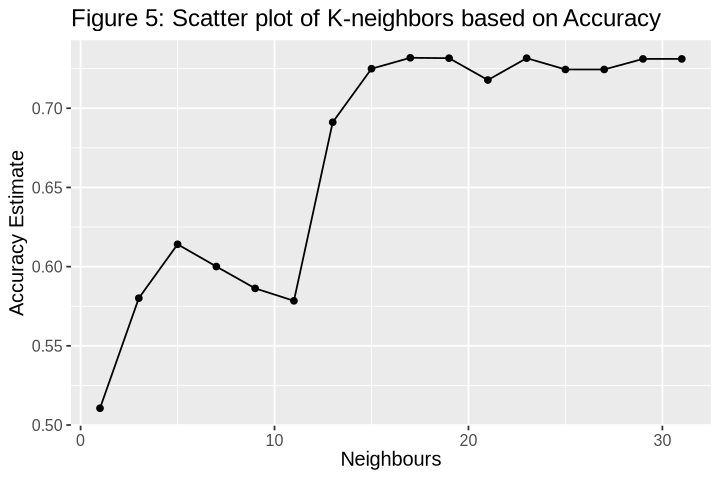

In [18]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) + 
                    geom_point() + 
                    geom_line() + 
                    labs(x = "Neighbours", y = "Accuracy Estimate",title="Figure 5: Scatter plot of K-neighbors based on Accuracy") + 
                    theme(text = element_text(size = 12))
accuracy_vs_k

In [19]:
best_k <- accuracies |> 
            arrange(desc(mean)) |> 
            head(1) |> 
            pull(neighbors)
best_k

[1] 17

In [22]:
knn_spec_17 <- nearest_neighbor(weight_func = "rectangular", neighbors = 17) |>
               set_engine("kknn") |>
               set_mode("classification")
knn_fit_17 <- workflow() |>
             add_recipe(players_recipe) |> 
             add_model(knn_spec_17) |> 
             fit(data = players_training)
players_test_predictions_17 <- predict(knn_fit_17, players_testing) |>
                                bind_cols(players_testing)
head(players_test_predictions_17)

accuracy_17 <- players_test_predictions_17 |> 
                metrics(truth = subscribe, estimate = .pred_class) |> 
                filter(.metric == "accuracy") |> 
                select(.estimate) |> 
                pull() 
accuracy_17

confusion_17 <-players_test_predictions_17 |> 
                conf_mat(truth = subscribe, estimate = .pred_class)
confusion_17

.pred_class,subscribe,played_hours,Age
<fct>,<fct>,<dbl>,<dbl>
TRUE,TRUE,3.8,17
TRUE,FALSE,0.0,17
TRUE,TRUE,0.7,21
TRUE,FALSE,0.0,21
TRUE,TRUE,0.0,17
TRUE,TRUE,48.4,17


[1] 0.7346939

          Truth
Prediction FALSE TRUE
     FALSE     0    0
     TRUE     13   36